In [1]:
!pip install xgboost

In [2]:
#Librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix

from sklearn.neighbors import  KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost.sklearn import XGBClassifier

from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

Vamos a definir una funcion (Mergeador_data) que tome el dataset de las observaciones y el dataset de DAM_GEODATA, haga un merge y se quede con los features de los que luego analizaremos la varianza

In [3]:
#Traemos los data frames

PVR_observaciones_18 = pd.read_csv('../Datasets/PVR_observaciones_promedio_cutoff18.csv')
PVR_observaciones_375 = pd.read_csv('../Datasets/PVR_observaciones_promedio_cutoff375.csv')
PVR_observaciones = pd.read_csv('../Datasets/PVR_Obs_Cutoff.csv', delimiter= ';')
PVR_DAM_geodata = pd.read_csv('../Datasets/PVR_DAM_geodata.csv', delimiter= ';')

def Mergeador_data (data2, data1):
    
    #Guardamos las variables en forma global, para llamarlas en cualquier momento
    global PVR_train_test, DAM_to_predict, PVR_train_test_copy
    
    #La funcion elimina los puntos del tipo intersección, Además guarda las intersecciones para luego hacer predicciones
    DAM_to_predict = data1[data1['punto_tipo'] == 'Intersercción']
    PVR_geodata = data1.drop(data1[data1['punto_tipo'] == 'Intersercción'].index)
    
    PVR_train_test = pd.merge(data2, data1 , how="left", on=["ID"]) 
    
    #Una vez que tenemos el PVR_train_test final, vamos a eliminar sus nulls
    PVR_train_test.dropna(axis=0, inplace= True)
    
    #Dejamos los features de ID, index, x, y, punto_tipo solo para las predicciones
    PVR_train_test_copy = PVR_train_test.copy()
    PVR_train_test.drop(['ID', 'index','x','y', 'punto_tipo', 'radio_censal'], axis=1, inplace= True)  
    
    #Hacemos dummies
    PVR_train_test = pd.get_dummies(PVR_train_test, drop_first=True)

In [4]:
#Invocamos al mergeador
Mergeador_data(PVR_observaciones_375, PVR_DAM_geodata)

In [5]:
PVR_train_test

,valoracion,poblacion,hogares,desocupado,0-14,65_mas,inicial,primario,egb,secundario,...,NoLee_ni_e,hacinamiento,sin_agua,sin_cloaca,densidad_comercial,microzonificacion_Comercial,microzonificacion_Residencial suburbano,microzonificacion_Residencial urbano,macrozonificacion_Interfaz,macrozonificacion_Urbano
0,0.0,848.0,259.0,39.0,190.0,97.0,35.0,124.0,80.0,180.0,...,40.0,1.0,0.0,23.0,0.0,0,0,1,0,1
1,1.0,620.0,215.0,17.0,101.0,103.0,16.0,79.0,42.0,156.0,...,22.0,1.0,0.0,0.0,7.0,0,0,1,0,1
2,1.0,519.0,245.0,9.0,65.0,132.0,11.0,73.0,12.0,119.0,...,14.0,0.0,0.0,0.0,5.0,1,0,0,0,0
3,1.0,519.0,245.0,9.0,65.0,132.0,11.0,73.0,12.0,119.0,...,14.0,0.0,0.0,0.0,5.0,1,0,0,0,0
4,1.0,664.0,268.0,21.0,104.0,120.0,16.0,103.0,12.0,154.0,...,18.0,2.0,2.0,0.0,2.0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,1.0,876.0,287.0,39.0,157.0,125.0,23.0,229.0,59.0,261.0,...,35.0,3.0,0.0,1.0,9.0,0,0,1,0,1
75,1.0,528.0,188.0,11.0,87.0,102.0,16.0,40.0,24.0,82.0,...,16.0,0.0,0.0,0.0,10.0,0,0,1,0,1
76,0.0,1190.0,351.0,23.0,208.0,113.0,43.0,76.0,103.0,141.0,...,44.0,0.0,66.0,3.0,2.0,0,1,0,1,0
77,1.0,784.0,305.0,27.0,106.0,122.0,18.0,116.0,26.0,194.0,...,23.0,1.0,5.0,0.0,11.0,0,0,1,0,1


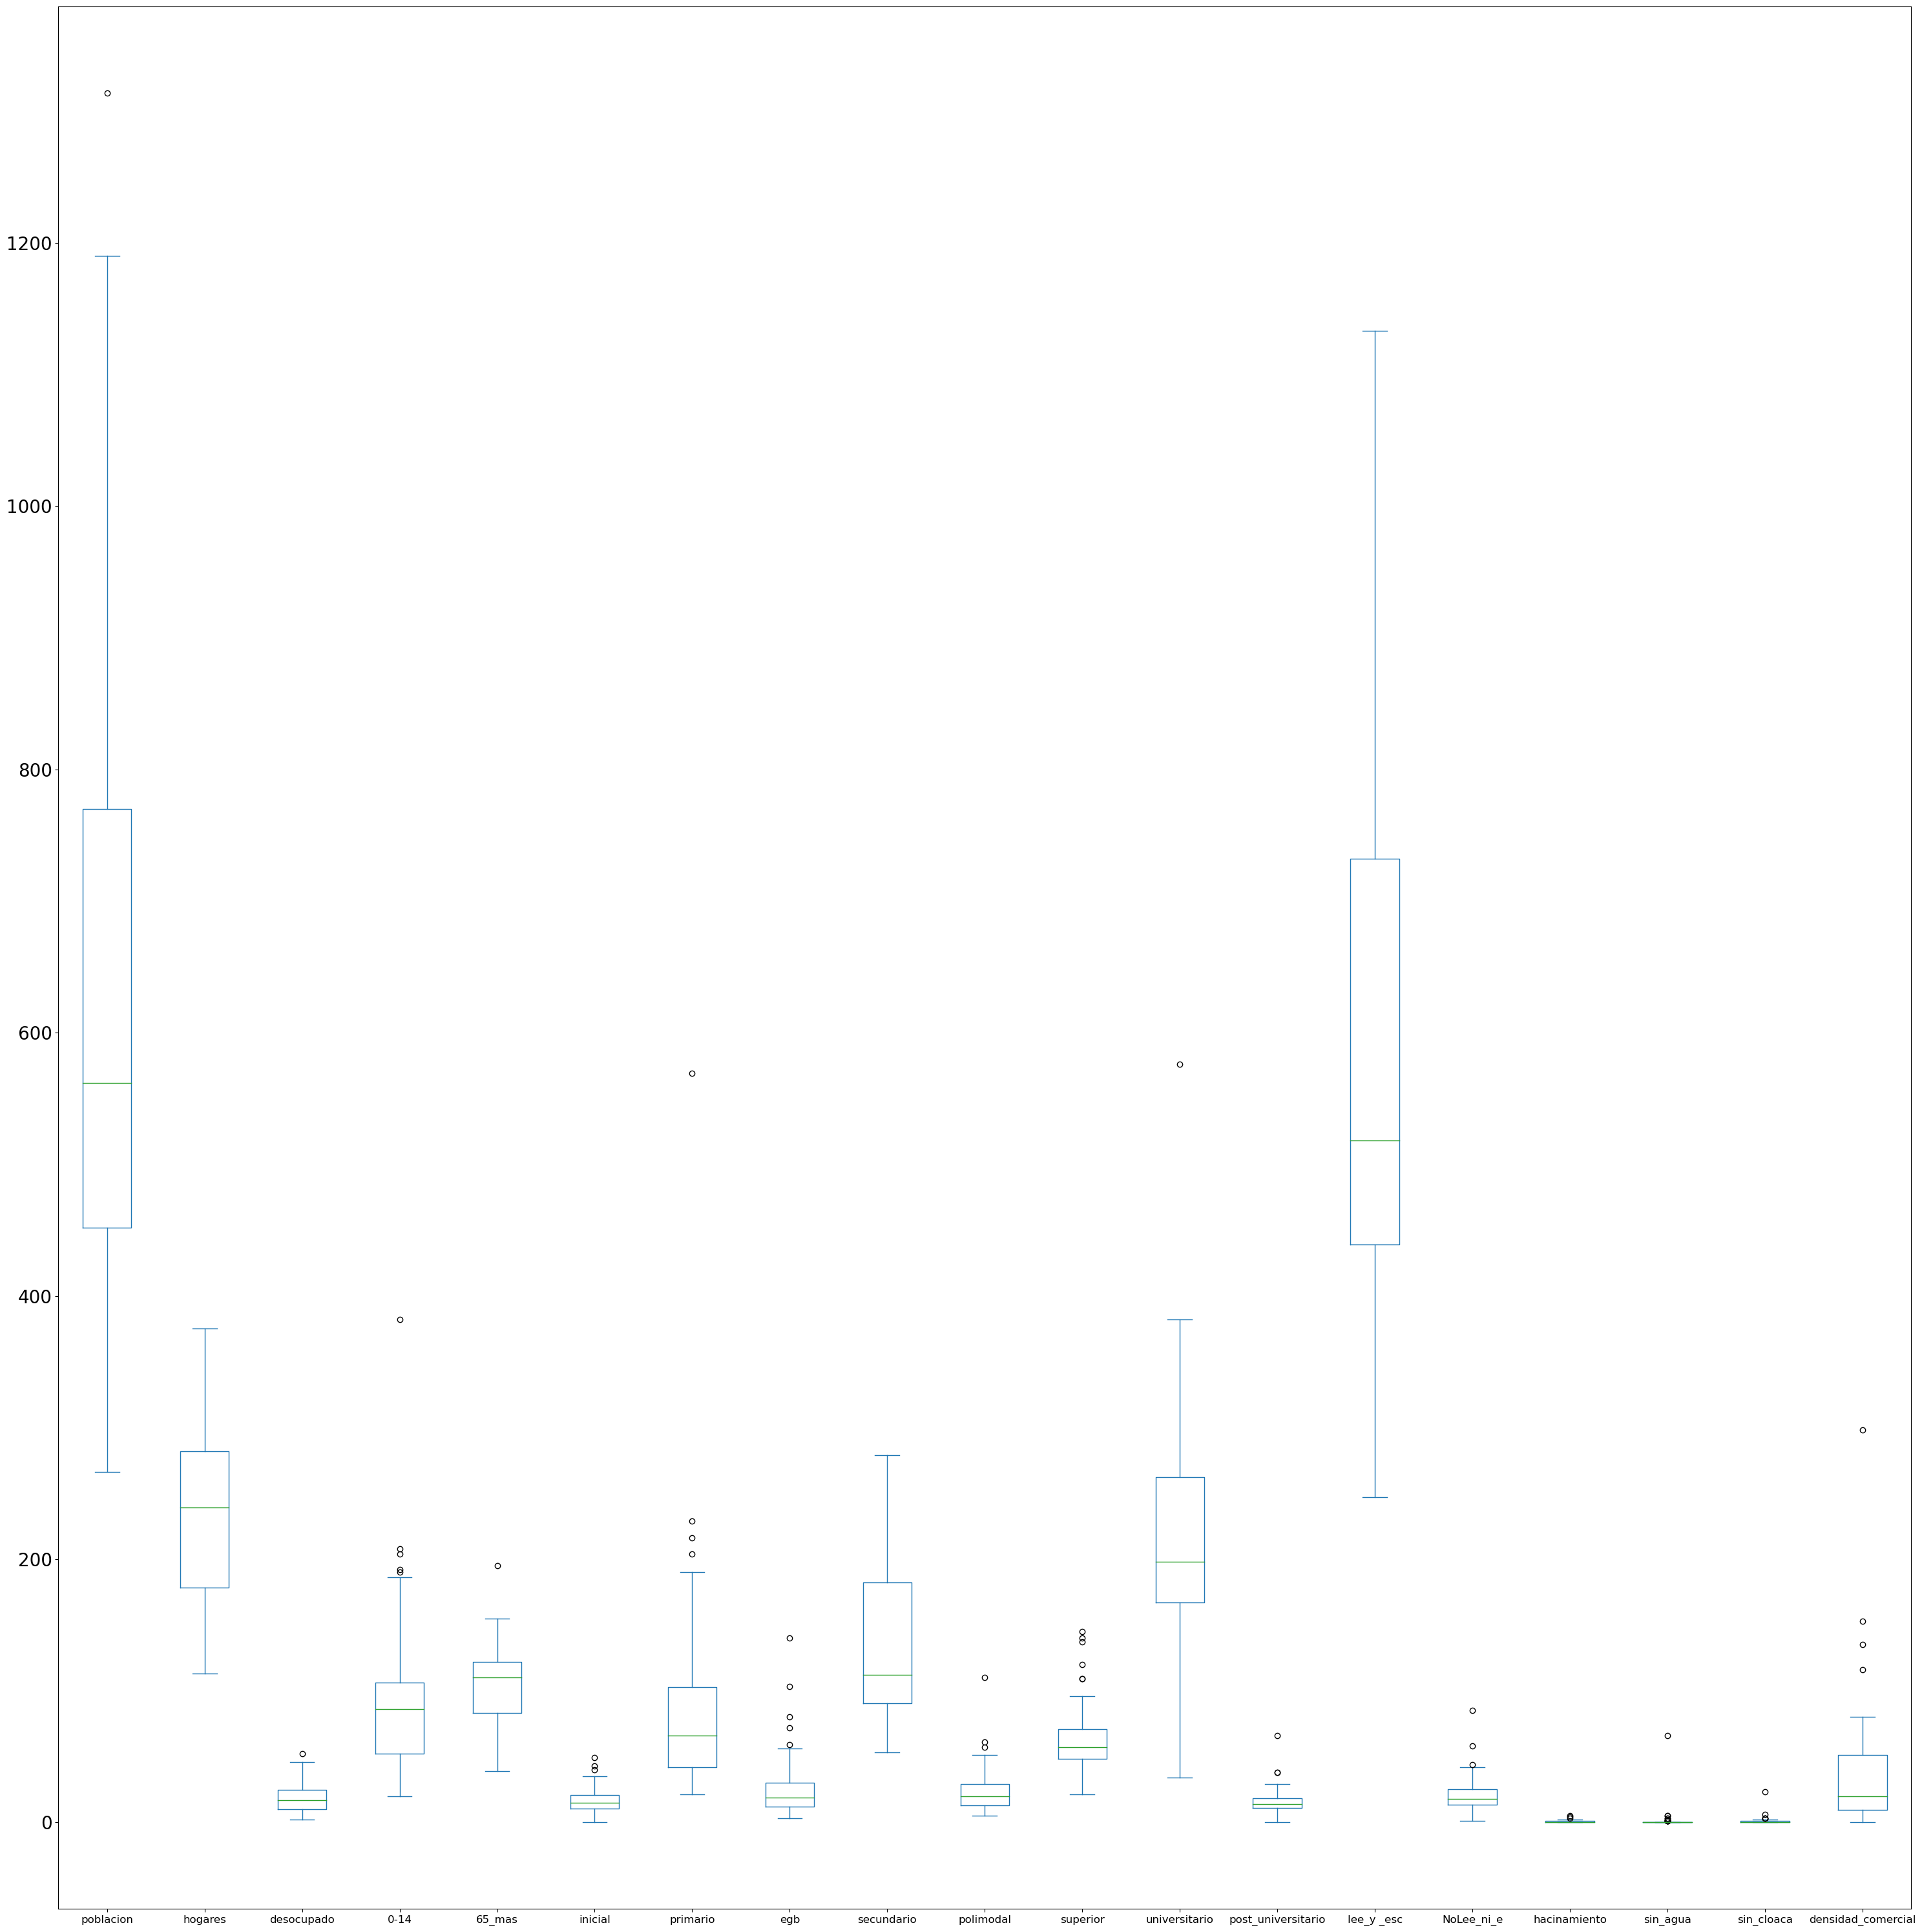

In [6]:
#Visualizacion de outliers

plt.rcParams["figure.figsize"] = [30, 30]
plt.rcParams["figure.autolayout"] = True

ax = PVR_train_test[['poblacion','hogares', 'desocupado', '0-14', '65_mas', 'inicial', 'primario', 'egb', 'secundario', 'polimodal', 'superior', 'universitario', 'post_universitario', 'lee_y _esc', 'NoLee_ni_e',
       'hacinamiento', 'sin_agua', 'sin_cloaca', 'densidad_comercial', ]].plot(kind='box')
plt.xticks(fontsize=12)
plt.yticks(fontsize=20)

plt.show()

In [7]:
def detect_outliers_iqr(data):
    outlier=[]

    data = sorted(data)
    q1= np.percentile(data,25)
    q3= np.percentile(data,75)
        
    IQR= q3-q1
    
    lwr_bound= q1 - (1.5*IQR)
    upr_bound = q3 + (1.5*IQR)
        
    
    for j in data:
        if (j<lwr_bound or j>upr_bound):
            outlier.append(j)
    
    return outlier

In [8]:
outlier = detect_outliers_iqr(PVR_train_test['egb'])
outlier

[59.0, 72.0, 80.0, 103.0, 140.0]

Ahora invocamos la función y creado el dataset hagamos otra que se quede con los mejores features, splitee los datos y nos guarde el dataset para entrenar.

In [9]:
def Preparando_data (data1):
    
    global x_train, x_test, y_train, y_test
    
    #Aca colocamos la seleccion de los mejores features 
    
    #Separamos el X y el target
    
    X = PVR_train_test[PVR_train_test.columns.difference(['valoracion'])]
    #X = PVR_train_test[['0-14', 'densidad_comercial', 'universitario', 'post_universitario', '65_mas']]
    y = PVR_train_test['valoracion']
    
    #Splieteamos
    x_train, x_test, y_train, y_test = train_test_split(X,y, stratify= y, test_size= 0.3, random_state= 9)
    
    #Estandarizamos los datos (lo dejamos muteado)
    #x_train_std, x_test_std = MinMaxScaler(x_train, x_test)
    
    print('La distribucion de etiquetas es: ', y_train.value_counts() / y_train.value_counts().sum())
    
       

In [10]:
#Generamos los datos para darle de comer al modelo
Preparando_data(PVR_train_test)

La distribucion de etiquetas es:  1.0    0.613636
0.0    0.386364
Name: valoracion, dtype: float64


# Bagging

In [11]:
classifier = {
    'KNeighbors': KNeighborsClassifier(),
    'LinearSCV': LinearSVC(),
    'SVC': SVC(),
    'SGDC': SGDClassifier(),
    'DecisionTree': DecisionTreeClassifier()
}

for name, estimator in classifier.items():
    bag_class = BaggingClassifier(
        base_estimator=estimator, n_estimators=5).fit(x_train, y_train)
    bag_pred = bag_class.predict(x_test)

    print('Accuracy Bagging with {}:'.format(
        name), accuracy_score(bag_pred, y_test))
    print('')


Accuracy Bagging with KNeighbors: 0.5263157894736842

Accuracy Bagging with LinearSCV: 0.3684210526315789

Accuracy Bagging with SVC: 0.5789473684210527

Accuracy Bagging with SGDC: 0.5789473684210527

Accuracy Bagging with DecisionTree: 0.5789473684210527



/Users/benjamin/anaconda3/envs/dhdsblend2021/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/benjamin/anaconda3/envs/dhdsblend2021/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/benjamin/anaconda3/envs/dhdsblend2021/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/benjamin/anaconda3/envs/dhdsblend2021/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/benjamin/anaconda3/envs/dhdsblend2021/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warni

# Boosting

In [12]:
cv = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)

params = {
    "n_estimators": [50, 100, 500],
    "max_depth": [1, 2, 3, 4],
    "learning_rate": [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1],
}

params2 = {
    "n_estimators": [50, 100, 500],
    "learning_rate": [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1],
}

# XG Boost

model_xg = XGBClassifier(n_jobs=-1, use_label_encoder=False)

xgb = GridSearchCV(model_xg, param_grid=params,
                   cv=cv, verbose=1, n_jobs=-1)

xgb.fit(x_train, y_train)

# Gradient Boosting

model_gb = GradientBoostingClassifier()

gb = GridSearchCV(model_gb, param_grid=params, cv=cv, verbose=1, n_jobs=-1)

gb.fit(x_train, y_train)

# Ada Boost

model_adb = AdaBoostClassifier()

adb = GridSearchCV(model_adb, param_grid=params2,
                   cv=cv, verbose=1, n_jobs=-1)

adb.fit(x_train, y_train)


Fitting 5 folds for each of 84 candidates, totalling 420 fits
Fitting 5 folds for each of 84 candidates, totalling 420 fits
Fitting 5 folds for each of 21 candidates, totalling 105 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=41, shuffle=True),
             estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.075, 0.1, 0.25, 0.5, 0.75,
                                           1],
                         'n_estimators': [50, 100, 500]},
             verbose=1)

# Mejores parámetros y matrices de confusión

In [13]:
classifiers = [AdaBoostClassifier(learning_rate=1, n_estimators=500),
               GradientBoostingClassifier(
                   learning_rate=0.75, max_depth=1, n_estimators=100),
               XGBClassifier(learning_rate=0.75, max_depth=3, n_estimators=50)]
for cls in classifiers:
    cls.fit(x_train, y_train)


/Users/benjamin/anaconda3/envs/dhdsblend2021/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/benjamin/anaconda3/envs/dhdsblend2021/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/benjamin/anaconda3/envs/dhdsblend2021/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confus

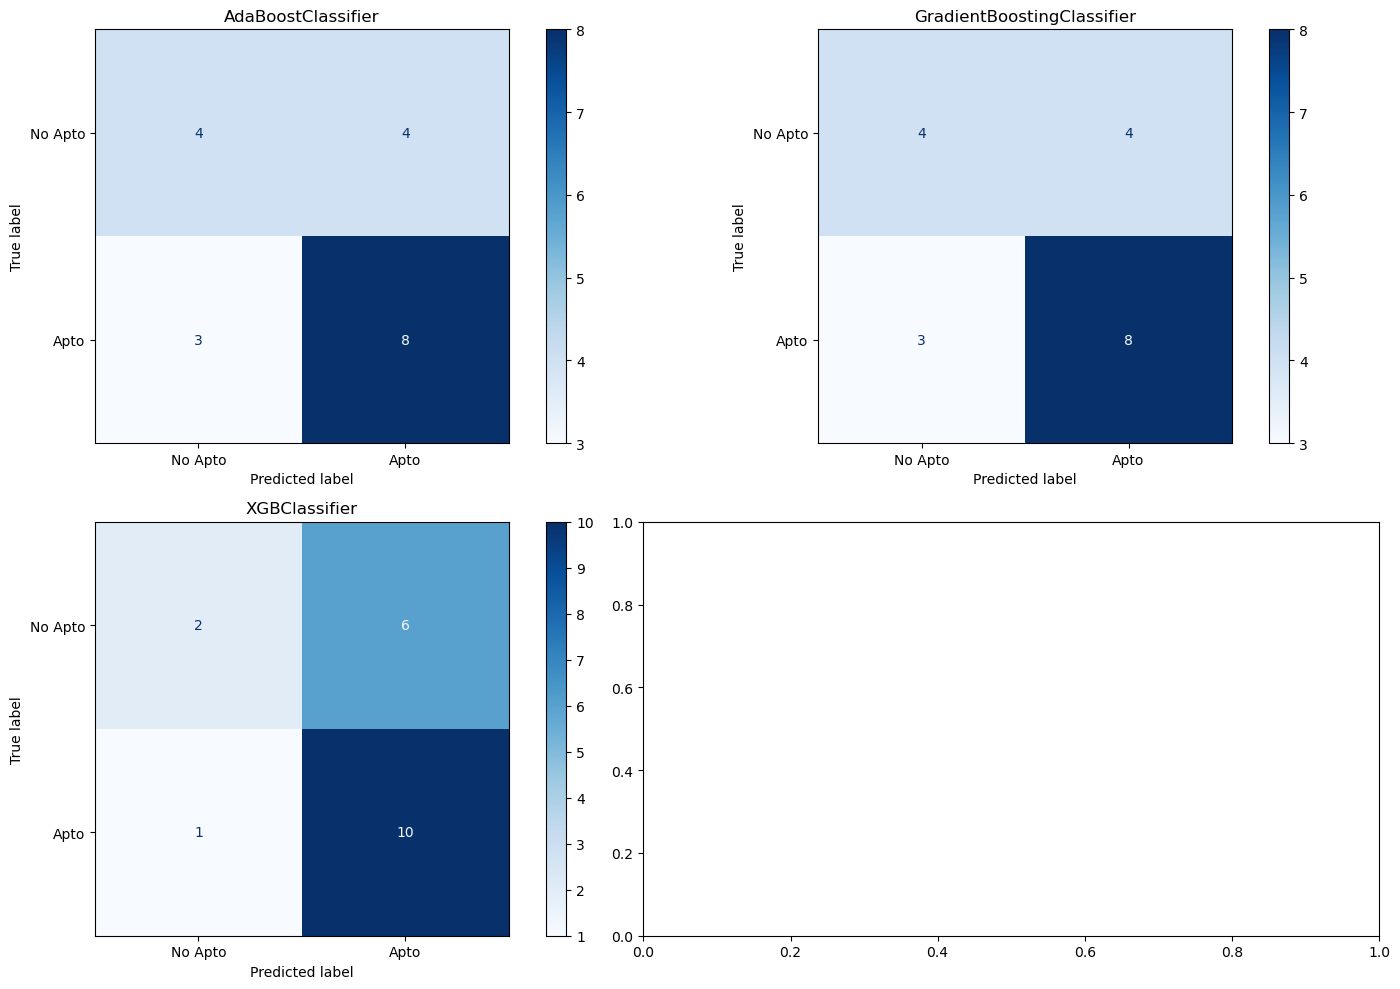

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

for cls, ax in zip(classifiers, axes.flatten()):
    plot_confusion_matrix(cls,
                          x_test,
                          y_test,
                          ax=ax,
                          cmap='Blues',
                          display_labels=['No Apto', 'Apto'])
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()
plt.show()


# Rendimiento para los modelos con cross validation

In [15]:
def evaluar_rendimiento(modelo, nombre, X, y, cv):
    s = cross_val_score(modelo, X, y, cv=cv, n_jobs=-1)
    print("Rendimiento de {}:\t{:0.3} ± {:0.3}".format(
        nombre, s.mean().round(3), s.std().round(3)))


In [16]:
evaluar_rendimiento(xgb.best_estimator_,"XG Boost", x_train, y_train, cv)

Rendimiento de XG Boost:	0.728 ± 0.051


**Mejor rendimiento por el momento**

In [17]:
evaluar_rendimiento(gb.best_estimator_,
                    "Gradient Boosting", x_train, y_train, cv)


Rendimiento de Gradient Boosting:	0.753 ± 0.106


In [18]:
evaluar_rendimiento(adb.best_estimator_,"Ada Boost", x_train, y_train, cv)

Rendimiento de Ada Boost:	0.683 ± 0.126


# Predicciones para las esquinas

Eliminamos los features que no necesitamos para hacer las predicciones

In [19]:

DAM_to_predict.dropna(axis=0, inplace=True)
DAM_to_predict.drop(DAM_to_predict[DAM_to_predict['microzonificacion']=='Especial Parque Gral. San Marti­n'].index, inplace=True)
DAM_to_predict.drop(DAM_to_predict[DAM_to_predict['microzonificacion']=='Especial UNCuyo'].index, inplace=True)
DAM_to_predict.drop(DAM_to_predict[DAM_to_predict['microzonificacion']=='Residencial de uso controlado'].index, inplace=True)
DAM_to_predict.drop(DAM_to_predict[DAM_to_predict['microzonificacion']=='Residencial piedemonte'].index, inplace=True)
DAM_to_predict.drop(DAM_to_predict[DAM_to_predict['microzonificacion']=='Area de Seguridad'].index, inplace=True)
DAM_to_predict.drop(DAM_to_predict[DAM_to_predict['microzonificacion']=='Especial Ex-Aeroparque'].index, inplace=True)
DAM_to_predict.drop(DAM_to_predict[DAM_to_predict['microzonificacion']=='Especial Ejercito'].index, inplace=True)
DAM_to_predict.drop(DAM_to_predict[DAM_to_predict['microzonificacion']=='Especial Club San Ceferino'].index, inplace=True)
DAM_to_predict.drop(DAM_to_predict[DAM_to_predict['microzonificacion']=='Natural de amortiguacion'].index, inplace=True)
DAM_to_predict.drop(DAM_to_predict[DAM_to_predict['microzonificacion']=='Zona de inundacion de dique'].index, inplace=True)
DAM_to_predict_final = DAM_to_predict.copy()

DAM_to_predict.drop(['ID', 'index','x','y', 'punto_tipo','radio_censal'], axis=1, inplace=True)

#Hacemos las dummies
data = pd.get_dummies(DAM_to_predict, drop_first=True)

<ipython-input-19-4989c14372fa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DAM_to_predict.dropna(axis=0, inplace=True)
<ipython-input-19-4989c14372fa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DAM_to_predict.drop(DAM_to_predict[DAM_to_predict['microzonificacion']=='Especial Parque Gral. San Marti­n'].index, inplace=True)
<ipython-input-19-4989c14372fa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DAM_to_predict.drop(DA

Predecimos para todas las esquinas

In [20]:
Predicciones = gb.best_estimator_.predict(data)

print(pd.DataFrame(Predicciones))
print(pd.DataFrame(Predicciones).value_counts())

        0
0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
...   ...
1843  1.0
1844  1.0
1845  0.0
1846  1.0
1847  1.0

[1848 rows x 1 columns]
0.0    1014
1.0     834
dtype: int64


/Users/benjamin/anaconda3/envs/dhdsblend2021/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [21]:
DAM_to_predict_final['clasificacion'] = Predicciones
DAM_to_predict_final['clasificacion'] = Predicciones


In [22]:
DAM_to_predict_final.to_csv("../Data/PVR_DAM_all.csv", index=False, encoding='utf-8-sig')